<a href="https://colab.research.google.com/github/ndvinh98/CS114.K21-Machine-Learning/blob/master/Project/Train_old_data_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Preprocessing***

### **Mount drive & install lib**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ln -s /content/drive/'My Drive'/Sentiment_Classification

In [ ]:
!pip install scikit-learn==0.23.1
!pip install underthesea
!pip install unidecode

### **import lib**

In [ ]:
import pandas as pd
import glob
import seaborn as sns
import string
from string import digits, punctuation
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.backend import clear_session
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from underthesea import word_tokenize
import unidecode
import joblib
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


### **Import data into Pandas**

In [ ]:
df_train= pd.read_csv('/content/Sentiment_Classification/data/train.csv')
df_test= pd.read_csv('/content/Sentiment_Classification/data/test.csv')

df_train.head(5)


,cau_goc,nhan
0,"cam ơn shop nhiều lam, e nhận dc máy rồi, sài...",1
1,Ngon như ăn cà,1
2,"Ve ngoai hinh khoang 96℅,mat kinh truoc va sau...",1
3,"lỗi vào 4G, phải khởi động lại máy thì mới chu...",0
4,"Đã mua và nhận xét : ngoại hình khá, màn hình ...",0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cau_goc  10000 non-null  object
 1   nhan     10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cau_goc  2537 non-null   object
 1   nhan     2537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.8+ KB


### **Data visualization**

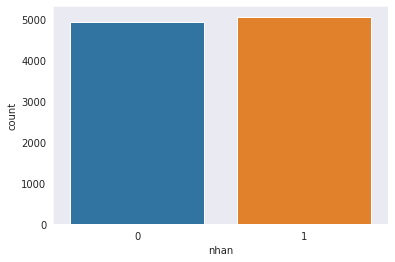

In [ ]:
sns.set_style("dark")
sns.countplot(df_train.nhan)

**See how comment look like**

In [ ]:
for i,content in enumerate (df_train['cau_goc'], 1):
    if i > 20:
        break
    else:
        print(i, content)

1 cam ơn shop nhiều lam, e nhận dc máy rồi,  sài ok lam, 😄😄😄😄
2 Ngon như ăn cà
3 Ve ngoai hinh khoang 96℅,mat kinh truoc va sau may co vet xuoc.loa e nay hoi be,xet ve gia tien oke.mih dung chi nghe goi,quan trong ben la oke.
4 lỗi vào 4G, phải khởi động lại máy thì mới chuyển E thành 4G, chuyển địa điểm khác bật 4G lên hiện E thì khởi động lại tiếp thì ok
5 Đã mua và nhận xét : ngoại hình khá, màn hình rất rỗ, ý kiến cá nhân mình thì nên bỏ cam trước và tăng độ phân giải màn hình lên tí nữa vì cam trước độ phân giải quá thấp nên chẳng mấy ai chụp hình với nó cả 
6 Máy bị lỗi giải quyết như thế nào shop oi.
7 Máy lướt web mau nóng máy,mặt lưng bám vân tay khá nhiều,cầm trơn trượt rất dễ rơi.pin mau hết..hơi thất vọng 
8 Sai lầm khi mua máy này. Sản phẩm bị lỗi quá nhiều. Đơ liên tục.ra tgdd họ k đổi cho mình đập luôn máy tại cửa hàng vì sản phẩm lừa khách hàng.k phát trực tiếp trên face.pjn 5k mà k bằng pin 2k.sắc mặt 5 tiếng .dùng chưa đến 2 tương hết pin
9 Máy xài rất ok Với giá tiền

### **Text cleansing**

In [ ]:
def standardize_data(df):
    hl_cleansed=[]
    for row in df:
        row = re.sub(r"[\.,\?]+$-", "", row)
        row = row.replace(",", " ").replace(".", " ") \
            .replace(";", " ").replace("“", " ") \
            .replace(":", " ").replace("”", " ") \
            .replace('"', " ").replace("'", " ") \
            .replace("!", " ").replace("?", " ") \
            .replace("-", " ").replace("?", " ")
        row = row.strip()
        hl_cleansed.append(row)
    return hl_cleansed

hl_cleansed=standardize_data(df_train['cau_goc'])
hl_cleansed_test=standardize_data(df_test['cau_goc'])
    
    
# View comparison
index=0
print('Original texts :')
print(df_train['cau_goc'][index])
print('\nAfter cleansed :')
print(hl_cleansed[index])

Original texts :
cam ơn shop nhiều lam, e nhận dc máy rồi,  sài ok lam, 😄😄😄😄

After cleansed :
cam ơn shop nhiều lam  e nhận dc máy rồi   sài ok lam  😄😄😄😄


**Tokenization, remove accents, remove stopwords**

In [ ]:
def vi_tokenizer(row):
    return word_tokenize(row, format="text")

def remove_accents(row):
  return unidecode.unidecode(row)

def remove_stopwords(stopwords,hl_split):
  sent = [s for s in hl_split if s not in stopwords ]
  return sent

stopwords=set(open('/content/Sentiment_Classification/data/stopwords.txt').read().split(' ')[:-1])

#for training set
hl_tokens = []
for hl in hl_cleansed:
    hl=vi_tokenizer(hl)
    clean=remove_stopwords(stopwords,hl.split())
    clean=[remove_accents(s) for s in clean]
    hl_tokens.append(clean)

#for testing set
hl_tokens_test = []
for hl in hl_cleansed_test:
    hl=vi_tokenizer(hl)
    clean=remove_stopwords(stopwords,hl.split())
    clean=[remove_accents(s) for s in clean]
    hl_tokens_test.append(clean)


# View Comparison
index=3
print('Before tokenization :')
print(hl_cleansed[index])
print('\nAfter tokenization :')
print(hl_tokens[index])

Before tokenization :
lỗi vào 4G  phải khởi động lại máy thì mới chuyển E thành 4G  chuyển địa điểm khác bật 4G lên hiện E thì khởi động lại tiếp thì ok

After tokenization :
['loi', '4G', 'khoi_dong', 'may', 'moi', 'chuyen', 'E', 'thanh', '4G', 'chuyen', 'dia_diem', 'khac', 'bat', '4G', 'hien', 'E', 'khoi_dong', 'tiep', 'ok']


### **Data Vectorization**

In [ ]:
max_features = 5000
max_token = len(max(hl_tokens,key=len))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_tokens)
sequences = tokenizer.texts_to_sequences(hl_tokens)
sequences_test = tokenizer.texts_to_sequences(hl_tokens_test)
X_Train = pad_sequences(sequences, maxlen=max_token)
X_test=pad_sequences(sequences_test, maxlen=max_token)

# View comparison
index=3
print('Original texts :')
print(df_train['cau_goc'][index])
print('\nAfter vectorization :')
print(X_Train[index])

Original texts :
lỗi vào 4G, phải khởi động lại máy thì mới chuyển E thành 4G, chuyển địa điểm khác bật 4G lên hiện E thì khởi động lại tiếp thì ok

After vectorization :
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   

# **Training with RNN**

## **Building the Model**

In [ ]:
Y_Train=df_train['nhan'].values
Y_Train = np.vstack(Y_Train)

Y_test=df_test['nhan'].values
Y_test=np.vstack(Y_test)

In [ ]:
clear_session()

In [ ]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model.add(Dense(150))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 64)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               14550     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150)               600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

## **Training process**

In [ ]:
epoch = 15
batch_size = 2048
history=model.fit(X_Train, Y_Train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/15
 - 3s - loss: 0.6627 - accuracy: 0.6047 - val_loss: 0.6873 - val_accuracy: 0.5105
Epoch 2/15
 - 2s - loss: 0.5188 - accuracy: 0.7835 - val_loss: 0.6745 - val_accuracy: 0.6070
Epoch 3/15
 - 2s - loss: 0.4001 - accuracy: 0.8290 - val_loss: 0.6562 - val_accuracy: 0.6745
Epoch 4/15
 - 2s - loss: 0.3022 - accuracy: 0.8783 - val_loss: 0.6444 - val_accuracy: 0.6580
Epoch 5/15
 - 2s - loss: 0.2403 - accuracy: 0.9034 - val_loss: 0.6316 - val_accuracy: 0.7140
Epoch 6/15
 - 2s - loss: 0.2087 - accuracy: 0.9151 - val_loss: 0.6100 - val_accuracy: 0.8675
Epoch 7/15
 - 2s - loss: 0.1745 - accuracy: 0.9301 - val_loss: 0.6003 - val_accuracy: 0.9015
Epoch 8/15
 - 2s - loss: 0.1493 - accuracy: 0.9446 - val_loss: 0.5997 - val_accuracy: 0.9175
Epoch 9/15
 - 2s - loss: 0.1302 - accuracy: 0.9528 - val_loss: 0.5899 - val_accuracy: 0.9330
Epoch 10/15
 - 2s - loss: 0.1187 - accuracy: 0.9565 - val_loss: 0.5767 - val_accuracy: 0.9355
Epoch 11/15
 - 2s - l

# ***Model Evaluation***



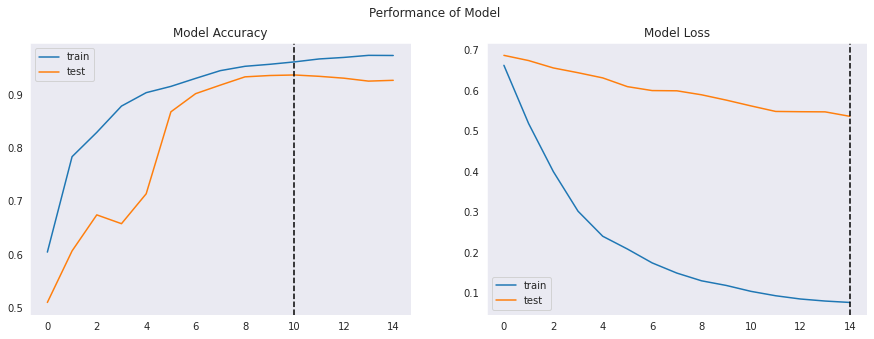

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

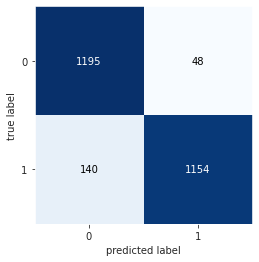

In [ ]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [ ]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1243
           1       0.96      0.89      0.92      1294

   micro avg       0.93      0.93      0.93      2537
   macro avg       0.93      0.93      0.93      2537
weighted avg       0.93      0.93      0.93      2537



# ***Use Another ML Algorithms to Training***

**Convert Data**

In [ ]:
X_Train = [" ".join(x) for x in hl_tokens]
X_test = [" ".join(x) for x in hl_tokens_test]
Y_Train=df_train['nhan'].values
Y_test=df_test['nhan'].values

cam on_shop lam e nhan dc may sai ok lam    


**Word Vectorization using TF-IDF**

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X_Train)
Train_X_Tfidf = Tfidf_vect.transform(X_Train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [ ]:
print(Tfidf_vect.vocabulary_)

{'cam': 1091, 'on_shop': 2970, 'lam': 2367, 'nhan': 2810, 'dc': 1469, 'may': 2583, 'sai': 3308, 'ok': 2954, 'ngon': 2774, 'an': 843, 'ca': 1080, 've': 4561, 'ngoai': 2766, 'hinh': 1927, 'khoang': 2201, '96': 686, 'mat': 2564, 'kinh': 2294, 'truoc': 4335, 'va': 4507, 'co': 1280, 'vet': 4576, 'xuoc': 4895, 'loa': 2444, 'nay': 2722, 'hoi': 1964, 'be': 994, 'xet': 4833, 'gia': 1771, 'tien': 4052, 'oke': 2959, 'mih': 2630, 'dung': 1662, 'chi': 1187, 'nghe': 2754, 'goi': 1825, 'quan': 3107, 'trong': 4308, 'ben': 998, 'la': 2360, 'loi': 2469, '4g': 465, 'khoi_dong': 2210, 'moi': 2658, 'chuyen': 1267, 'thanh': 3819, 'dia_diem': 1559, 'khac': 2142, 'bat': 977, 'hien': 1909, 'tiep': 4068, 'da': 1371, 'mua': 2686, 'nhan_xet': 2819, 'ngoai_hinh': 2767, 'kha': 2135, 'man_hinh': 2550, 'ro': 3239, 'y_kien': 4922, 'ca_nhan': 1081, 'minh': 2633, 'bo': 1037, 'tang': 3705, 'do': 1595, 'phan_giai': 3011, 'ti': 4036, 'qua': 3095, 'thap': 3844, 'chang': 1162, 'ai': 801, 'chup': 1261, 'no': 2900, 'giai_quyet

## **Trainning on the SVM classifier**

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Y_Train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=True)

**Predict and evaluate the SVM classifier**

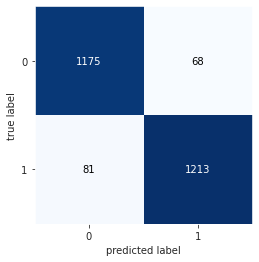

In [ ]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,predictions_SVM))
plt.show()

In [ ]:
print(classification_report(Y_test,predictions_SVM))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1243
           1       0.95      0.94      0.94      1294

   micro avg       0.94      0.94      0.94      2537
   macro avg       0.94      0.94      0.94      2537
weighted avg       0.94      0.94      0.94      2537



## **Trainning on the Naive Bayes Classifier**

In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Y_Train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Predict and evaluate the Naive Bayes Classifier**

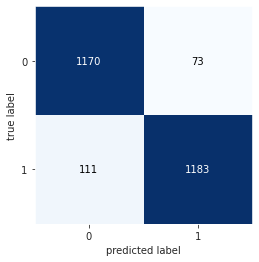

In [ ]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,predictions_NB))
plt.show()

In [ ]:
print(classification_report(Y_test,predictions_NB))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1243
           1       0.94      0.91      0.93      1294

   micro avg       0.93      0.93      0.93      2537
   macro avg       0.93      0.93      0.93      2537
weighted avg       0.93      0.93      0.93      2537



# ***Save model***

In [ ]:
joblib.dump(Tfidf_vect, '/content/Sentiment_Classification/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/Sentiment_Classification/model/tokenizer_LSTM.pkl')
joblib.dump(model, '/content/Sentiment_Classification/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/Sentiment_Classification/model/SVM_model.pkl')
joblib.dump(Naive, '/content/Sentiment_Classification/model/NB_model.pkl')
joblib.dump(Tfidf_vect.vocabulary_, '/content/Sentiment_Classification/model/vocabulary.pkl')

['/content/Sentiment_Classification/model/vocabulary.pkl']

# ***Enter comment and test***

## *utils*

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

path='/content/Sentiment_Classification/'
stopwords=set(open(path+'data/stopwords.txt').read().split(' ')[:-1])

  

def vi_tokenizer(row):
  return word_tokenize(row, format="text")

def remove_accents(row):
  return unidecode.unidecode(row)

def remove_stopwords(hl_split):
  sent = [s for s in hl_split if s not in stopwords]
  return sent

def text_cleasing(row):
  row = re.sub(r"[\.,\?]+$-", "", row)
  row = row.replace(",", " ").replace(".", " ") \
      .replace(";", " ").replace("“", " ") \
      .replace(":", " ").replace("”", " ") \
      .replace('"', " ").replace("'", " ") \
      .replace("!", " ").replace("?", " ") \
      .replace("-", " ").replace("?", " ")
  row = row.strip()
  row=vi_tokenizer(row)
  row=remove_stopwords(row.split())
  row=[remove_accents(s) for s in row]
  #row=[" ".join(x) for x in row]
  return row

def input_vectorization(input_token,tokenizer):
  arr_token=[]
  arr_token.append(input_token)
  max_token=250
  sequences = tokenizer.texts_to_sequences(arr_token)
  X = pad_sequences(sequences, maxlen=max_token)
  return X
       

def LSTM_predict(text,model,tokenizer):
  token=text_cleasing(text)
  X=input_vectorization(token,tokenizer)
  if np.around(model.predict(X))==1:
    print(text)
    print("=============> Positive\n")
  else:
    print(text)
    print("=============> Negative\n")

def predict(text,model,tfidf_vector):
  token=text_cleasing(text)
  token=[' '.join(token)]
  X_Tfidf = tfidf_vector.transform(token)
  if model.predict(X_Tfidf)[0]==1:
    print(text)
    print("=============> Positive\n")
  else:
    print(text)
    print("=============> Negative\n")



## Predict

Load model 

In [ ]:
model_LSTM=joblib.load(path+'model/LSTM_model.pkl')
tokenizer_LSTM=joblib.load(path+'model/tokenizer_LSTM.pkl')
SVM_model=joblib.load(path+'model/SVM_model.pkl')
NB_model=joblib.load(path+'model/NB_model.pkl')
tfidf_vec=joblib.load(path+'model/tfidf.pkl')

Using LSTM model to predict

In [ ]:
cmt='Đã đặt mua lần thứ n, và vẫn cảm thấy hài lòng với shop...'

cmt2='Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????'

cmt3='máy như cục cứt, xài được vài bữa hư màn hình'



LSTM_predict(cmt,model_LSTM,tokenizer_LSTM)
LSTM_predict(cmt2,model_LSTM,tokenizer_LSTM)
LSTM_predict(cmt3,model_LSTM,tokenizer_LSTM)



Đã đặt mua lần thứ n, và vẫn cảm thấy hài lòng với shop...
=============> Positive

Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????
=============> Negative

máy như cục cứt, xài được vài bữa hư màn hình
=============> Negative



Using SVM clasifier

In [ ]:
predict(cmt,SVM_model,tfidf_vec)
predict(cmt2,SVM_model,tfidf_vec)
predict(cmt3,SVM_model,tfidf_vec)

Đã đặt mua lần thứ n, và vẫn cảm thấy hài lòng với shop...
=============> Positive

Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????
=============> Negative

máy như cục cứt, xài được vài bữa hư màn hình
=============> Negative



Using NB clasifier


In [ ]:
predict(cmt,NB_model,tfidf_vec)
predict(cmt2,NB_model,tfidf_vec)
predict(cmt3,NB_model,tfidf_vec)

Đã đặt mua lần thứ n, và vẫn cảm thấy hài lòng với shop...
=============> Positive

Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????
=============> Negative

máy như cục cứt, xài được vài bữa hư màn hình
=============> Negative

